In [1]:
## helpful packages
import pandas as pd
import numpy as np
import random
import re
import recordlinkage
from sklearn.feature_extraction.text import TfidfVectorizer
## nltk imports
from nltk.tokenize import word_tokenize, wordpunct_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from gensim import corpora, models
# ! pip install xlrd
# ! pip install openpyxl
## lda 
from gensim import corpora
import gensim

## repeated printouts
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
# load data
addendum = pd.read_csv("FOIA_2021-F-05932_raw_data_combined.csv")
disclosure = pd.read_csv ("H-2A_Disclosure_Data_FY_combined.csv")

/opt/conda/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (17,18,31) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
# Dropping duplicates in addenda

## perhaps we want to create a priority order for which section we should keep if the
## same data is inputted in multiple sections?

len(addendum)
addendum = addendum.drop_duplicates(["CASE_NUMBER", "SECTION_DETAILS"])
len(addendum)

102317

99620

In [4]:
## collapsing identical case/sections into one listing each

addendum.sort_values(["CASE_NUMBER", "SECTION_NUMBER"])

addendum["SECTION_DETAILS"].to_string()

addendum = addendum.groupby(['CASE_NUMBER'])['SECTION_DETAILS'].apply(lambda text: ''.join(text.to_string(index=False))).str.replace('(\\n)', '').reset_index()



CASE_NUMBER                                       SECTION_NAME  \
23      H-300-19274-066154                                     Pay Deductions   
16      H-300-19274-066154                                   Job Requirements   
18      H-300-19274-066154                                   Job Requirements   
19      H-300-19274-066154                                   Job Requirements   
22      H-300-19274-066154                                     Meal Provision   
...                    ...                                                ...   
101081  H-300-20356-972294             Job Requirements - Housing Rules 10-25   
101147  H-300-20356-972294  Job Requirements - A6/ Anticipated days and ho...   
101274  H-300-20366-985558  Job Duties - OTHER CLARIFICATIONS AND ASSURANC...   
101421  H-300-20366-985558  Job Duties - OTHER CLARIFICATIONS AND ASSURANC...   
101429  H-300-20366-985558             Inbound/Outbound Transportation - null   

       SECTION_NUMBER                                    SECTION_DETAILS  
23               A.11  Reasonable repair cost of damage from delibera...  
16                B.6  Operating large farm tractors and equipment as...  
18                B.6  Should the Employers worker’s compensation ins...  
19                B.6  Three (3) months experience required for the j...  
22                E.1  Employer will furnish free and convenient cook...  
...               ...                                                ...  
101081            B.6  10.\tWorkers living in employer's housing may ...  
101147            B.6  Anticipated Hours of Work: Worker will report ...  
101274           A.8a  OTHER CLARIFICATIONS AND ASSURANCES: \n\nWORKE...  
101421           A.8a  TERMS AND CONDITION CHANGES:  The employer wil...  
101429            F.2  The employer will also provide advance subsist...  

[99620 rows x 4 columns]

'0         Employer will furnish free and convenient cook...\n1         Three (3) months experience with references re...\n2         Living & laundry facilities available. Housing...\n3         Should the Employers worker’s compensation ins...\n4         The employer shall provide transportation in t...\n5         Reasonable repair cost of damage from delibera...\n6         Operating large farm tractors and equipment as...\n7         Alternatively, the employer may, at his or her...\n8         Please contact  the employer point of contact ...\n9         Employer provided transportation will be airpl...\n10        worker departed to work for employer, except w...\n11        worker departed to work for employer, except w...\n12        INBOUND 1) Advance the worker the required tra...\n13        The employer will provide, at no cost to the w...\n14         whether in the U.S. or abroad to the place of...\n15        The employer provides the worker with a cell p...\n16        Operating lar

<ipython-input-4-97679c173e43>:7: FutureWarning: The default value of regex will change from True to False in a future version.
  addendum = addendum.groupby(['CASE_NUMBER'])['SECTION_DETAILS'].apply(lambda text: ''.join(text.to_string(index=False))).str.replace('(\\n)', '').reset_index()


In [5]:
## Above code modified from fifth answer at https://stackoverflow.com/questions/27298178/concatenate-strings-from-several-rows-using-pandas-groupby
## because original groupby was including a bunch of linebreaks

In [6]:
# Rename Column
addendum = addendum.rename(columns = {"SECTION_DETAILS":"JOB_DESCRIPTION"})

In [7]:
#Remove Job Listings that Contain Spanish Words
spanish_words = ['compensación',
 'ocupación',
 'pago',
 'transporte',
 'reglas',
 'contrato',
 'horastrabajadores',
 'parte',
 'tarifas',
 'cuartos',
 'trabajo',
 'registros',
 'adicionales',
 'comidas',
 'empleo',
 'terminación',
 'vivienda',
 'empleador',
 'adicionales',
 'frecuencia',
 'producción',
 'liquidación',
 'comida',
 'herramientas',
 'prueba',
 'diaria',
 'tarifas',
 'parado',
 'adicionales',
 'cobertura',
 'proporcionados',
 'parte',
 'abandono',
 'deducciones',
 'causa',
 'garantías',
 'divulgación',
 'comidas',
 'política',
 'disciplina',
 'despidos',
 'derechos',
 'imposibilidad',
 'detalles',
 'divulgación',
 'bloqueo',
 'abandono',
 'ganancias',
 'cobertura',
 'pedidos',
 'pago',
 'oportunidad',
 'trabajo']

addendum = addendum[~addendum.JOB_DESCRIPTION.str.contains('|'.join(spanish_words))]
print(len(addendum))


11763


In [8]:
## Text Processing
def processtext(row, colname, stopword_list, min_token_length = 4):
    
    ## get string form of listing
    string_of_col = str(row[colname]).lower()
    try:
        ## remove stopwords 
        remove_stop = [word for word in wordpunct_tokenize(string_of_col)
                      if word not in stopword_list]
        processed_string = " ".join([porter.stem(i) 
                        for i in remove_stop if 
                        i.isalpha() and len(i) >= min_token_length])
        return(processed_string)
    except:
        processed_string = "" # to handle data errors where not actually text
        return(processed_string)
    
other_stopwords = ["after", "before", "employer", "employ", "job", "work", "worker"]

list_stopwords = stopwords.words("english")

stopwords_complete = list_stopwords + other_stopwords
    
porter = PorterStemmer()



In [9]:
stopwords_complete = list_stopwords + other_stopwords

addendum['text_preprocess'] = addendum.apply(processtext,
                             axis = 1,
                             args = ["JOB_DESCRIPTION", stopwords_complete])
addendum.head()

CASE_NUMBER                                    JOB_DESCRIPTION  \
0  H-300-19274-066154  Operating large farm tractors and equipment as...   
1  H-300-19274-066174  Employer will furnish free and convenient cook...   
2  H-300-19274-066180  INBOUND 1) Advance the worker the required tra...   
3  H-300-19274-066199  For workers who are provided housing, transpor...   
4  H-300-19274-066237  The inbound transportation will be reimbursed ...   

                                     text_preprocess  
0  oper larg farm tractor equip pleas contact poi...  
1  furnish free conveni cooki three month experi ...  
2  inbound advanc requir tran provid cost whether...  
3  worker provid hous transport previous advanc t...  
4                         inbound transport reimburs

In [10]:
#Make Sure all the rows under EMPLOYER_STATE has two digit state code
disclosure.EMPLOYER_STATE=disclosure.EMPLOYER_STATE.astype("string")
disclosure=disclosure[~disclosure.EMPLOYER_STATE.isnull()]
assert all(disclosure.EMPLOYER_STATE.str.len()==2), "All the states in debar are not two-digits after the cleaning"

# Label TRLA Catchment State VS Remaining States
disclosure["TRLA"] = np.where((disclosure["EMPLOYER_STATE"] == "TX") | 
                                          (disclosure["EMPLOYER_STATE"] == "MS")|(disclosure["EMPLOYER_STATE"] == "LA")|
                              (disclosure["EMPLOYER_STATE"] == "KY")|(disclosure["EMPLOYER_STATE"] == "AL")|(disclosure["EMPLOYER_STATE"] == 
                                                                                                          "TN"), True, False)
disclosure.TRLA.value_counts()

False    11966
True      4801
Name: TRLA, dtype: int64

In [11]:
#Merging

In [12]:
# merging testing code (fully applicable after data cleaning and the necessary steps above)
## left join  
merged_data_left = pd.merge(disclosure,
                             addendum,
                             left_on = 'CASE_NUMBER',
                             right_on = 'CASE_NUMBER',
                             how = "left",
                             indicator = "case_merge_status")
merged_data_left.case_merge_status.value_counts()
merged_data_left

both          11742
left_only      5025
right_only        0
Name: case_merge_status, dtype: int64

CASE_NUMBER                           CASE_STATUS RECEIVED_DATE  \
0      H-300-20265-835437  Determination Issued - Certification     2020/9/24   
1      H-300-20260-827678  Determination Issued - Certification     2020/9/16   
2      H-300-20260-827308  Determination Issued - Certification     2020/9/16   
3      H-300-20260-826330  Determination Issued - Certification     2020/9/18   
4      H-300-20259-823987      Determination Issued - Withdrawn     2020/9/18   
...                   ...                                   ...           ...   
16762  H-300-20351-963307  Determination Issued - Certification    2020/12/17   
16763  H-300-20351-963399  Determination Issued - Certification    2020/12/17   
16764  H-300-20351-964097  Determination Issued - Certification    2020/12/22   
16765  H-300-20351-965435  Determination Issued - Certification    2020/12/22   
16766  H-300-20352-967311  Determination Issued - Certification    2020/12/22   

      DECISION_DATE  TYPE_OF_EMPLOYER_APPLICATION H2A_LABOR_CONTRACTOR  \
0         2020/9/30           Individual Employer                    Y   
1         2020/9/24  Association - Joint Employer                    N   
2         2020/9/24           Association - Agent                    N   
3         2020/9/30           Individual Employer                    N   
4         2020/9/29           Individual Employer                    N   
...             ...                           ...                  ...   
16762    2020/12/31           Individual Employer                    N   
16763    2020/12/31           Individual Employer                    N   
16764    2020/12/31           Individual Employer                    N   
16765    2020/12/31           Individual Employer                    N   
16766    2020/12/31           Individual Employer                    N   

      NATURE_OF_TEMPORARY_NEED EMERGENCY_FILING              EMPLOYER_NAME  \
0                     Seasonal                N        Benito Martinez Jr.   
1                     Seasonal                N  WESTERN RANGE ASSOCIATION   
2                     Seasonal                N          Allen Ranches LLC   
3                     Seasonal                N                Steven Edge   
4                     Seasonal                N                 Floyd Frey   
...                        ...              ...                        ...   
16762                 Seasonal                N          James L Schneller   
16763                 Seasonal                N            Stephen G Myers   
16764                 Seasonal                N                 Andy Povey   
16765                 Seasonal                N     Silver Creek Seed, LLC   
16766                 Seasonal                N             Halabura Farms   

         TRADE_NAME_DBA  ... MEAL_REIMBURSEMENT_MINIMUM  \
0                   NaN  ...                     $12.68   
1                   NaN  ...                     $12.68   
2                   NaN  ...                     $12.68   
3                   NaN  ...                     $12.68   
4                   NaN  ...                     $12.68   
...                 ...  ...                        ...   
16762               NaN  ...                     $12.68   
16763               NaN  ...                     $12.68   
16764  Andy Povey Farms  ...                     $12.68   
16765               NaN  ...                     $12.68   
16766               NaN  ...                     $12.68   

      MEAL_REIMBURSEMENT_MAXIMUM PHONE_TO_APPLY  \
0                         $55.00    14073199505   
1                         $55.00    12085952226   
2                         $55.00    13074722105   
3                         $55.00    18433407334   
4                         $55.00    14062650953   
...                          ...            ...   
16762                     $55.00    12709914373   
16763                     $55.00    12708780028   
16764                     $55.00            NaN

In [13]:
# ## look at one that doesnt have job listing
merged_left_check=merged_data_left[merged_data_left.case_merge_status=="left_only"]
disclosure[['ANTICIPATED_NUMBER_OF_HOURS', 'WAGE_OFFER', 'TOTAL_WORKERS_NEEDED']].dtypes
merged_left_check[['ANTICIPATED_NUMBER_OF_HOURS', 'WAGE_OFFER', 'TOTAL_WORKERS_NEEDED']].dtypes
merged_left_check['WAGE_OFFER'] = merged_left_check['WAGE_OFFER'].str.replace('$', '')
merged_left_check['WAGE_OFFER'] = merged_left_check['WAGE_OFFER'].str.replace(',', '')
merged_left_check['WAGE_OFFER'] = merged_left_check['WAGE_OFFER'].astype(float)
disclosure['WAGE_OFFER'] = disclosure['WAGE_OFFER'].str.replace('$', '')
disclosure['WAGE_OFFER'] = disclosure['WAGE_OFFER'].str.replace(',', '')
disclosure['WAGE_OFFER']= disclosure['WAGE_OFFER'].astype(float)
disclosure[['ANTICIPATED_NUMBER_OF_HOURS', 'WAGE_OFFER', 'TOTAL_WORKERS_NEEDED']].dtypes
merged_left_check[['ANTICIPATED_NUMBER_OF_HOURS', 'WAGE_OFFER', 'TOTAL_WORKERS_NEEDED']].dtypes

ANTICIPATED_NUMBER_OF_HOURS    float64
WAGE_OFFER                      object
TOTAL_WORKERS_NEEDED           float64
dtype: object

ANTICIPATED_NUMBER_OF_HOURS    float64
WAGE_OFFER                      object
TOTAL_WORKERS_NEEDED           float64
dtype: object

<ipython-input-13-0d80f0a3ecd0>:5: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  merged_left_check['WAGE_OFFER'] = merged_left_check['WAGE_OFFER'].str.replace('$', '')
<ipython-input-13-0d80f0a3ecd0>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_left_check['WAGE_OFFER'] = merged_left_check['WAGE_OFFER'].str.replace('$', '')
<ipython-input-13-0d80f0a3ecd0>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/sta

ANTICIPATED_NUMBER_OF_HOURS    float64
WAGE_OFFER                     float64
TOTAL_WORKERS_NEEDED           float64
dtype: object

ANTICIPATED_NUMBER_OF_HOURS    float64
WAGE_OFFER                     float64
TOTAL_WORKERS_NEEDED           float64
dtype: object

In [14]:
disclosure.loc[:, disclosure.dtypes == np.float64]

disclosure.agg(
        {
         "WAGE_OFFER": ["median"],
         "TOTAL_WORKERS_NEEDED": ["median"],
        "ANTICIPATED_NUMBER_OF_HOURS": ["median"],
            "PIECE_RATE_OFFER": ["median"],
            "WORK_EXPERIENCE_MONTHS" : ["median"],
            "TOTAL_OCCUPANCY" : ["median"],
            "LIFTING_AMOUNT" : ["median"]
        })
merged_left_check.agg(
        {
         "WAGE_OFFER": ["median"],
         "TOTAL_WORKERS_NEEDED": ["median"],
        "ANTICIPATED_NUMBER_OF_HOURS": ["median"],
        "PIECE_RATE_OFFER": ["median"],
        "WORK_EXPERIENCE_MONTHS" : ["median"],
        "TOTAL_OCCUPANCY" : ["median"],
        "LIFTING_AMOUNT" : ["median"]}
        )

disclosure.TRLA.value_counts()
#percentage of non TRLA states is higher
#compare wages? is it that there's lower wage rate so there's no listing?


NAICS_CODE  EMPLOYER_POC_PHONE_EXT  ATTORNEY_AGENT_PHONE_EXT  \
0        115115.0                     NaN                       NaN   
1        112410.0                     NaN                       NaN   
2        112410.0                     NaN                       NaN   
3        112112.0                     NaN                       NaN   
4          1121.0                     NaN                       NaN   
...           ...                     ...                       ...   
16778    111191.0                     NaN                       NaN   
16779      1111.0                     NaN                       NaN   
16780      1119.0                     NaN                       NaN   
16781       111.0                     NaN                       NaN   
16782    111421.0                     NaN                       NaN   

       TOTAL_WORKERS_NEEDED  TOTAL_WORKERS_H2A_CERTIFIED  \
0                      14.0                         14.0   
1                       1.0                          1.0   
2                       3.0                          3.0   
3                       2.0                          2.0   
4                       2.0                          NaN   
...                     ...                          ...   
16778                   3.0                          3.0   
16779                   2.0                          2.0   
16780                   4.0                          4.0   
16781                   7.0                          7.0   
16782                   8.0                          8.0   

       ANTICIPATED_NUMBER_OF_HOURS  SUNDAY_HOURS  MONDAY_HOURS  TUESDAY_HOURS  \
0                             36.0           0.0           6.0            6.0   
1                              NaN           NaN           NaN            NaN   
2                              NaN           NaN           NaN            NaN   
3                             48.0           0.0           8.0            8.0   
4                             37.5           0.0           7.5            7.5   
...                            ...           ...           ...            ...   
16778                         48.0           0.0           8.0            8.0   
16779                         40.0           0.0           8.0            8.0   
16780                         48.0           0.0           8.0            8.0   
16781                         50.0           0.0           9.0            9.0   
16782                         53.0           0.0           9.0            9.0   

       WEDNESDAY_HOURS  ...  PIECE_RATE_OFFER  WORK_EXPERIENCE_MONTHS  \
0                  6.0  ...               0.0                     1.0   
1                  NaN  ...               0.0                     3.0   
2                  NaN  ...               0.0                     6.0   
3                  8.0  ...               NaN                     3.0   
4                  7.5  ...               NaN                     3.0   
...                ...  ...               ...                     ...   
16778              8.0  ...               NaN                     3.0   
16779              8.0  ...               NaN                     3.0   
16780              8.0  ...               0.0                     0.0   
16781              9.0  ...               0.0                     0.0   
16782              9.0  ...               NaN                     3.0   

       TRAINING_MONTHS  LIFTING_AMOUNT  SUPERVISE_HOW_MANY  \
0                  0.0            20.0                 NaN   
1                  0.0            50.0                 NaN   
2                  0.0            50.0                 NaN   
3                  0.0            60.0                 NaN   
4                  0.0           100.0                 NaN   
...                ...             ...                 ...   
16778              0.0            75.0                 NaN   
16779              0.0            75.0                 NaN   
16780              0.0   

WAGE_OFFER  TOTAL_WORKERS_NEEDED  ANTICIPATED_NUMBER_OF_HOURS  \
median       13.34                   6.0                         40.0   

        PIECE_RATE_OFFER  WORK_EXPERIENCE_MONTHS  TOTAL_OCCUPANCY  \
median               0.0                     3.0              8.0   

        LIFTING_AMOUNT  
median            60.0

WAGE_OFFER  TOTAL_WORKERS_NEEDED  ANTICIPATED_NUMBER_OF_HOURS  \
median       12.67                   5.0                         40.0   

        PIECE_RATE_OFFER  WORK_EXPERIENCE_MONTHS  TOTAL_OCCUPANCY  \
median               0.0                     3.0              8.0   

        LIFTING_AMOUNT  
median            60.0

False    11966
True      4801
Name: TRLA, dtype: int64

In [15]:
## inner join  
merged_data = pd.merge(addendum,
                             disclosure,
                             left_on = 'CASE_NUMBER',
                             right_on = 'CASE_NUMBER',
                             how = "inner",
                             indicator = "case_merge_status")
merged_data.case_merge_status.value_counts()


both          11742
left_only         0
right_only        0
Name: case_merge_status, dtype: int64

In [26]:
# ## look at one that doesnt have job listing
merged_left_check=merged_data_left[merged_data_left.case_merge_status=="left_only"]
merged_data[['ANTICIPATED_NUMBER_OF_HOURS', 'WAGE_OFFER', 'TOTAL_WORKERS_NEEDED']].dtypes
merged_left_check[['ANTICIPATED_NUMBER_OF_HOURS', 'WAGE_OFFER', 'TOTAL_WORKERS_NEEDED']].dtypes
merged_left_check['WAGE_OFFER'] = merged_left_check['WAGE_OFFER'].str.replace('$', '')
merged_left_check['WAGE_OFFER'] = merged_left_check['WAGE_OFFER'].str.replace(',', '')
merged_left_check['WAGE_OFFER'] = merged_left_check['WAGE_OFFER'].astype(float)
#merged_data['WAGE_OFFER'] = merged_data['WAGE_OFFER'].str.replace('$', '')
#merged_data['WAGE_OFFER'] = merged_data['WAGE_OFFER'].str.replace(',', '')
#merged_data['WAGE_OFFER']= merged_data['WAGE_OFFER'].astype(float)
merged_data[['ANTICIPATED_NUMBER_OF_HOURS', 'WAGE_OFFER', 'TOTAL_WORKERS_NEEDED']].dtypes
merged_left_check[['ANTICIPATED_NUMBER_OF_HOURS', 'WAGE_OFFER', 'TOTAL_WORKERS_NEEDED']].dtypes


ANTICIPATED_NUMBER_OF_HOURS    float64
WAGE_OFFER                     float64
TOTAL_WORKERS_NEEDED           float64
dtype: object

ANTICIPATED_NUMBER_OF_HOURS    float64
WAGE_OFFER                      object
TOTAL_WORKERS_NEEDED           float64
dtype: object

<ipython-input-26-1e0c6c56006a>:5: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  merged_left_check['WAGE_OFFER'] = merged_left_check['WAGE_OFFER'].str.replace('$', '')
<ipython-input-26-1e0c6c56006a>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_left_check['WAGE_OFFER'] = merged_left_check['WAGE_OFFER'].str.replace('$', '')
<ipython-input-26-1e0c6c56006a>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/sta

ANTICIPATED_NUMBER_OF_HOURS    float64
WAGE_OFFER                     float64
TOTAL_WORKERS_NEEDED           float64
dtype: object

ANTICIPATED_NUMBER_OF_HOURS    float64
WAGE_OFFER                     float64
TOTAL_WORKERS_NEEDED           float64
dtype: object

In [28]:
merged_data.loc[:, merged_data.dtypes == np.float64]

merged_data.agg(
        {
         "WAGE_OFFER": ["median"],
         "TOTAL_WORKERS_NEEDED": ["median"],
        "ANTICIPATED_NUMBER_OF_HOURS": ["median"],
            "PIECE_RATE_OFFER": ["median"],
            "WORK_EXPERIENCE_MONTHS" : ["median"],
            "TOTAL_OCCUPANCY" : ["median"],
            "LIFTING_AMOUNT" : ["median"]
        })
merged_left_check.agg(
        {
         "WAGE_OFFER": ["median"],
         "TOTAL_WORKERS_NEEDED": ["median"],
        "ANTICIPATED_NUMBER_OF_HOURS": ["median"],
        "PIECE_RATE_OFFER": ["median"],
        "WORK_EXPERIENCE_MONTHS" : ["median"],
        "TOTAL_OCCUPANCY" : ["median"],
        "LIFTING_AMOUNT" : ["median"]}
        )

disclosure.TRLA.value_counts()
#percentage of non TRLA states is higher
#compare wages? is it that there's lower wage rate so there's no listing?


NAICS_CODE  EMPLOYER_POC_PHONE_EXT  ATTORNEY_AGENT_PHONE_EXT  \
0        111191.0                     NaN                       NaN   
1        112910.0                     NaN                       NaN   
2         11241.0                     NaN                       NaN   
3          1125.0                     NaN                       NaN   
4         11131.0                     NaN                       NaN   
...           ...                     ...                       ...   
11737    111191.0                     NaN                       NaN   
11738     11119.0                     NaN                       NaN   
11739       111.0                     NaN                       NaN   
11740    111421.0                     NaN                       NaN   
11741    115115.0                     NaN                       0.0   

       TOTAL_WORKERS_NEEDED  TOTAL_WORKERS_H2A_CERTIFIED  \
0                       1.0                          NaN   
1                       9.0                          NaN   
2                       1.0                          1.0   
3                       4.0                          4.0   
4                      34.0                         34.0   
...                     ...                          ...   
11737                   4.0                          4.0   
11738                   6.0                          5.0   
11739                   7.0                          7.0   
11740                  13.0                          9.0   
11741                  60.0                          NaN   

       ANTICIPATED_NUMBER_OF_HOURS  SUNDAY_HOURS  MONDAY_HOURS  TUESDAY_HOURS  \
0                             40.0           0.0           7.0            7.0   
1                             48.0           0.0           9.0            9.0   
2                              NaN           NaN           NaN            NaN   
3                             35.0           0.0           7.0            7.0   
4                             40.0           0.0           7.0            7.0   
...                            ...           ...           ...            ...   
11737                         40.0           0.0           7.0            7.0   
11738                         40.0           0.0           7.0            7.0   
11739                         50.0           0.0           9.0            9.0   
11740                         40.0           0.0           7.0            7.0   
11741                         48.0           0.0           8.0            8.0   

       WEDNESDAY_HOURS  ...  PIECE_RATE_OFFER  WORK_EXPERIENCE_MONTHS  \
0                  7.0  ...               NaN                     3.0   
1                  9.0  ...               NaN                     3.0   
2                  NaN  ...               NaN                     6.0   
3                  7.0  ...             12.23                     3.0   
4                  7.0  ...              1.00                     1.0   
...                ...  ...               ...                     ...   
11737              7.0  ...               NaN                     3.0   
11738              7.0  ...               NaN                     3.0   
11739              9.0  ...              0.00                     0.0   
11740              7.0  ...               NaN                     3.0   
11741              8.0  ...              0.00                     3.0   

       TRAINING_MONTHS  LIFTING_AMOUNT  SUPERVISE_HOW_MANY  \
0                  0.0            75.0                 NaN   
1                  0.0            75.0                 NaN   
2                  0.0           100.0                 NaN   
3                  0.0            50.0                 NaN   
4                  0.0           100.0                 NaN   
...                ...             ...                 ...   
11737              0.0            75.0                 NaN   
11738              0.0            75.0                 NaN   
11739              0.0   

WAGE_OFFER  TOTAL_WORKERS_NEEDED  ANTICIPATED_NUMBER_OF_HOURS  \
median       13.62                   6.0                         40.0   

        PIECE_RATE_OFFER  WORK_EXPERIENCE_MONTHS  TOTAL_OCCUPANCY  \
median               0.0                     3.0              8.0   

        LIFTING_AMOUNT  
median            60.0

WAGE_OFFER  TOTAL_WORKERS_NEEDED  ANTICIPATED_NUMBER_OF_HOURS  \
median       12.67                   5.0                         40.0   

        PIECE_RATE_OFFER  WORK_EXPERIENCE_MONTHS  TOTAL_OCCUPANCY  \
median               0.0                     3.0              8.0   

        LIFTING_AMOUNT  
median            60.0

False    11966
True      4801
Name: TRLA, dtype: int64

In [16]:
#Subset Data to TRLA catchment

merged_TRLA=merged_data[merged_data.TRLA==True]
merged_TRLA
#Subset Data to remaining states
merged_nonTRLA=merged_data[merged_data.TRLA==False]
merged_nonTRLA

CASE_NUMBER                                    JOB_DESCRIPTION  \
1      H-300-19274-066174  Employer will furnish free and convenient cook...   
3      H-300-19274-066199  For workers who are provided housing, transpor...   
6      H-300-19274-066444  Employer will pay for or reimburse the worker ...   
7      H-300-19275-067016  The employer will reimburse the worker for the...   
8      H-300-19275-067031  Employer will provide workers with transportat...   
...                   ...                                                ...   
11656  H-300-20343-941481  Bonuses and/or wages that are higher than the ...   
11660  H-300-20343-941606  16.\tAny worker who physically threatens anoth...   
11672  H-300-20343-942095  Employer may reward exceptional work with mone...   
11730  H-300-20351-963307  Operating tools and equipment as applicable an...   
11731  H-300-20351-963399  Workers who qualify for inbound and/or outboun...   

                                         text_preprocess  \
1      furnish free conveni cooki three month experi ...   
3      worker provid hous transport previous advanc t...   
6                 reimburs actual employ offer sole disc   
7      reimburs request hour nthe demand competit bus...   
8      provid worker transportati reimburs demand com...   
...                                                  ...   
11656  bonus wage higher requir avail hour tool suppl...   
11660  tani physic threaten anoth although intend com...   
11672                                reward except monet   
11730  oper tool equip applic furnish free conveni co...   
11731                    worker qualifi inbound outbound   

                                CASE_STATUS RECEIVED_DATE DECISION_DATE  \
1          Determination Issued - Withdrawn     2019/10/1     2019/10/4   
3      Determination Issued - Certification    2019/10/18    2019/11/12   
6      Determination Issued - Certification     2019/10/1    2019/11/18   
7      Determination Issued - Certification     2019/10/4    2019/11/15   
8      Determination Issued - Certification     2019/10/4    2019/11/21   
...                                     ...           ...           ...   
11656  Determination Issued - Certification     2020/12/8    2020/12/31   
11660  Determination Issued - Certification     2020/12/9    2020/12/28   
11672  Determination Issued - Certification    2020/12/11    2020/12/21   
11730  Determination Issued - Certification    2020/12/17    2020/12/31   
11731  Determination Issued - Certification    2020/12/17    2020/12/31   

      TYPE_OF_EMPLOYER_APPLICATION H2A_LABOR_CONTRACTOR  \
1              Individual Employer                    N   
3              Individual Employer                    N   
6              Individual Employer                    N   
7              Individual Employer                    N   
8              Individual Employer                    N   
...                            ...                  ...   
11656          Association - Agent                    N   
11660          Association - Agent                    N   
11672          Individual Employer                    N   
11730          Individual Employer                    N   
11731          Individual Employer                    N   

      NATURE_OF_TEMPORARY_NEED EMERGENCY_FILING  ... MEALS_PROVIDED  \
1                     Seasonal                N  ...              N   
3                     Seasonal                N  ...              N   
6                     Seasonal                N  ...              N   
7                     Seasonal                N  ...              N   
8                     Seasonal                N  ...              N   
...                        ...              ...  ...            ...   
11656                 Seasonal                N  ...              N   
11660                 Seasonal                N  ...              N   
11672                 Seasonal                N  ...              N   
11730       

CASE_NUMBER                                    JOB_DESCRIPTION  \
0      H-300-19274-066154  Operating large farm tractors and equipment as...   
2      H-300-19274-066180  INBOUND 1) Advance the worker the required tra...   
4      H-300-19274-066237  The inbound transportation will be reimbursed ...   
5      H-300-19274-066365  Alternatively, the employer may, at his or her...   
9      H-300-19275-067184  Alternatively, the employer may, at his or her...   
...                   ...                                                ...   
11737  H-300-20351-965074  Employer will furnish free and convenient cook...   
11738  H-300-20351-965273  The number of workers shown is the aggregate n...   
11739  H-300-20351-965435  Inbound transportation and subsistence fees wi...   
11740  H-300-20356-972294  16.\tWorker may not falsify identification, pe...   
11741  H-300-20366-985558  OTHER CLARIFICATIONS AND ASSURANCES: \n\nWORKE...   

                                         text_preprocess  \
0      oper larg farm tractor equip pleas contact poi...   
2      inbound advanc requir tran provid cost whether...   
4                             inbound transport reimburs   
5                                                 altern   
9                                                 altern   
...                                                  ...   
11737  furnish free conveni cooki employ compens insu...   
11738  number worker shown aggreg equip oper field op...   
11739  inbound transport subsist fee duti requir spli...   
11740  tworker falsifi identif hous rule tthi hous te...   
11741  clarif assur nworker term condit chang also pr...   

                                          CASE_STATUS RECEIVED_DATE  \
0                    Determination Issued - Withdrawn     2019/10/1   
2                Determination Issued - Certification     2019/10/2   
4      Determination Issued - Certification (Expired)    2019/10/18   
5                    Determination Issued - Withdrawn     2019/10/4   
9      Determination Issued - Certification (Expired)    2019/10/11   
...                                               ...           ...   
11737            Determination Issued - Certification    2020/12/17   
11738            Determination Issued - Certification    2020/12/17   
11739            Determination Issued - Certification    2020/12/22   
11740            Determination Issued - Certification    2020/12/21   
11741                Determination Issued - Withdrawn    2020/12/30   

      DECISION_DATE TYPE_OF_EMPLOYER_APPLICATION H2A_LABOR_CONTRACTOR  \
0        2019/10/23          Individual Employer                    N   
2        2019/10/18          Individual Employer                    N   
4         2019/12/2          Individual Employer                    Y   
5         2019/10/4          Individual Employer                    N   
9        2019/11/15          Individual Employer                    N   
...             ...                          ...                  ...   
11737    2020/12/23          Individual Employer                    N   
11738    2020/12/22          Individual Employer                    N   
11739    2020/12/31          Individual Employer                    N   
11740    2020/12/29               Joint Employer                    N   
11741    2020/12/30          Individual Employer                    Y   

      NATURE_OF_TEMPORARY_NEED EMERGENCY_FILING  ... MEALS_PROVIDED  \
0                     Seasonal                N  ...              N   
2                     Seasonal                N  ...              N   
4                     Seasonal                N  ...              N   
5                     Seasonal                N  ...              N   
9                     Seasonal                N  ...              N   
...                        ...              ...  ...            ...   
11737                 Seasonal                N  ...              N   
11738                 Seasonal    

([<matplotlib.patches.Wedge at 0x7f8a6c9e8580>,
 [Text(-0.7477217706495162, 0.8067912702160037, 'Non-TRLA'),
  Text(0.7477217706495161, -0.8067912702160037, 'TRLA')],
 [Text(-0.4078482385360997, 0.4400679655723656, '73.8%'),
  Text(0.40784823853609964, -0.4400679655723656, '26.2%')])

Text(0.5, 1.0, 'Jobs without Listings (Before Merge)')

Text(0.5, 1.0, 'Jobs with Listings')

([<matplotlib.patches.Wedge at 0x7f8a3d588d30>,
 [Text(-0.6841570595548822, 0.8613530738676316, 'Non-TRLA'),
  Text(0.684157059554882, -0.8613530738676317, 'TRLA')],
 [Text(-0.3731765779390266, 0.46982894938234443, '71.4%'),
  Text(0.37317657793902653, -0.46982894938234454, '28.6%')])

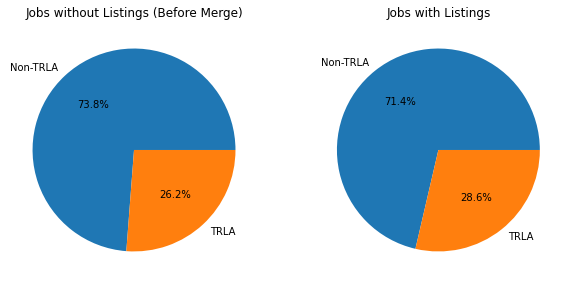

In [45]:

data = [3708, 1317]
labels = ['Non-TRLA', 'TRLA']  
# Print the output
data2 = [11966, 4801]

fig, (plt1,plt2) = plt.subplots(1,2,figsize=(10,10))
plt1.pie(data, labels=labels, autopct='%1.1f%%')
plt1.set_title("Jobs without Listings (Before Merge)")
plt2.set_title("Jobs with Listings")
plt2.pie(data2, labels=labels, autopct='%1.1f%%')

In [17]:
## topic modeling (Top Words In Combined Data)
vectorizer = TfidfVectorizer()
tf_idf = vectorizer.fit_transform(merged_data['text_preprocess'])
top_combined = pd.DataFrame(tf_idf.toarray(), columns=vectorizer.get_feature_names())
top_combined.sum(axis=0).sort_values(ascending=False).head(10)

worker       972.281521
provid       748.928728
transport    612.770280
complet      532.019871
termin       470.511803
hous         463.696189
advanc       450.541257
requir       444.695451
subsist      384.799561
inbound      382.561694
dtype: float64

In [18]:
## topic modeling (Top Words In TRLA)
vectorizer = TfidfVectorizer()
tf_idf = vectorizer.fit_transform(merged_nonTRLA['text_preprocess'])
top_combined_TRLA = pd.DataFrame(tf_idf.toarray(), columns=vectorizer.get_feature_names())
top_combined_TRLA.sum(axis=0).sort_values(ascending=False).head(10)

worker       680.029314
provid       590.677363
transport    478.561728
termin       416.962515
advanc       405.318280
requir       386.504611
hous         342.223064
subsist      341.129475
inbound      338.848663
offer        263.010323
dtype: float64

In [19]:
## topic modeling (Top Words In Non-TRLA)
vectorizer = TfidfVectorizer()
tf_idf = vectorizer.fit_transform(merged_TRLA['text_preprocess'])
top_combined_nonTRLA = pd.DataFrame(tf_idf.toarray(), columns=vectorizer.get_feature_names())
top_combined_nonTRLA.sum(axis=0).sort_values(ascending=False).head(10)

worker      365.497361
complet     317.096067
time        254.771197
appli       242.341893
domest      239.945642
tani        239.399262
threaten    239.399262
anoth       239.383324
legal       239.098346
physic      238.843095
dtype: float64

In [20]:
## topic modeling (TRLA states)

merged_TRLA = merged_TRLA[merged_TRLA.text_preprocess != ""].copy()

tokenized_text_TRLA = [wordpunct_tokenize(one_text) for one_text in 
                                      merged_TRLA.text_preprocess]

## preprocess and estimate topicmod
### create dictionary
text_proc_dict_TRLA = corpora.Dictionary(tokenized_text_TRLA)
### filter dictionary- using 2% as bounds
text_proc_dict_TRLA.filter_extremes(no_below = round(merged_TRLA.shape[0]*0.02),
                             no_above = round(merged_TRLA.shape[0]*0.98))

### create corpus from dictionary
corpus_fromdict_proc = [text_proc_dict_TRLA.doc2bow(one_text) 
                   for one_text in tokenized_text_TRLA]

tfidf = models.TfidfModel(corpus_fromdict_proc)
corpus_tfidf = tfidf[corpus_fromdict_proc]

lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf, num_topics=4, id2word=text_proc_dict_TRLA, passes=6,
                                        per_word_topics = True, random_state = 91988)

topics = lda_model_tfidf.print_topics(num_words = 10)
for topic in topics:
    print(topic)

(0, '0.056*"tobacco" + 0.056*"assign" + 0.053*"nworker" + 0.050*"begin" + 0.049*"pull" + 0.047*"sucker" + 0.033*"must" + 0.033*"worker" + 0.027*"time" + 0.026*"week"')
(1, '0.051*"transport" + 0.049*"contact" + 0.034*"shall" + 0.032*"point" + 0.032*"provid" + 0.030*"cooki" + 0.030*"conveni" + 0.030*"reason" + 0.029*"furnish" + 0.028*"repair"')
(2, '0.050*"mechan" + 0.050*"vari" + 0.038*"avail" + 0.029*"rule" + 0.027*"time" + 0.021*"hous" + 0.020*"provid" + 0.020*"hour" + 0.019*"employe" + 0.019*"advanc"')
(3, '0.066*"complet" + 0.062*"appli" + 0.061*"anoth" + 0.061*"tani" + 0.061*"threaten" + 0.061*"legal" + 0.060*"physic" + 0.060*"domest" + 0.060*"although" + 0.058*"list"')


In [21]:
## topic modeling (nonTRLA states)

merged_nonTRLA = merged_nonTRLA[merged_nonTRLA.text_preprocess != ""].copy()

tokenized_text_nonTRLA = [wordpunct_tokenize(one_text) for one_text in 
                                      merged_nonTRLA.text_preprocess]

## preprocess and estimate topicmod
### create dictionary
text_proc_dict_nonTRLA = corpora.Dictionary(tokenized_text_nonTRLA)
### filter dictionary- using 2% as bounds
text_proc_dict_nonTRLA.filter_extremes(no_below = round(merged_nonTRLA.shape[0]*0.02),
                             no_above = round(merged_nonTRLA.shape[0]*0.98))

### create corpus from dictionary
corpus_fromdict_proc_non = [text_proc_dict_nonTRLA.doc2bow(one_text) 
                   for one_text in tokenized_text_nonTRLA]

tfidf_non = models.TfidfModel(corpus_fromdict_proc_non)
corpus_tfidf_non = tfidf[corpus_fromdict_proc_non]

lda_model_tfidf_non = gensim.models.LdaMulticore(corpus_tfidf_non, num_topics=4, id2word=text_proc_dict_nonTRLA, passes=6,
                                        per_word_topics = True, random_state = 91988)

topics_nontrla = lda_model_tfidf_non.print_topics(num_words = 10)
for topic in topics_nontrla:
    print(topic)

(0, '0.096*"provid" + 0.076*"complet" + 0.051*"worker" + 0.039*"place" + 0.034*"contract" + 0.029*"advanc" + 0.026*"offer" + 0.026*"nthe" + 0.024*"cont" + 0.024*"number"')
(1, '0.047*"worker" + 0.038*"hous" + 0.029*"harvest" + 0.028*"offer" + 0.027*"tworker" + 0.026*"provid" + 0.025*"follow" + 0.025*"hour" + 0.024*"rule" + 0.020*"monday"')
(2, '0.109*"inbound" + 0.060*"requir" + 0.057*"day" + 0.053*"need" + 0.051*"offer" + 0.046*"instruct" + 0.045*"outbound" + 0.044*"transport" + 0.044*"subsist" + 0.042*"qualifi"')
(3, '0.070*"transport" + 0.043*"suppli" + 0.042*"tool" + 0.036*"equip" + 0.035*"wage" + 0.032*"bonus" + 0.029*"higher" + 0.026*"employe" + 0.023*"phone" + 0.022*"provid"')


In [22]:
## topic modeling (whole document)
 
merged_data = merged_data[merged_data.text_preprocess != ""].copy()

tokenized_text_all = [wordpunct_tokenize(one_text) for one_text in 
                                      merged_data.text_preprocess]

## preprocess and estimate topicmod
### create dictionary
text_proc_dict_all = corpora.Dictionary(tokenized_text_all)
### filter dictionary- using 2% as bounds
text_proc_dict_all.filter_extremes(no_below = round(merged_data.shape[0]*0.02),
                             no_above = round(merged_data.shape[0]*0.98))

### create corpus from dictionary
corpus_fromdict_proc_all = [text_proc_dict_all.doc2bow(one_text) 
                   for one_text in tokenized_text_all]

tfidf_all = models.TfidfModel(corpus_fromdict_proc_all)
corpus_tfidf_all = tfidf[corpus_fromdict_proc_all]

lda_model_tfidf_all = gensim.models.LdaMulticore(corpus_tfidf_all, num_topics=4, id2word=text_proc_dict_all, passes=6,
                                        per_word_topics = True, random_state = 91988)

topics_all = lda_model_tfidf_all.print_topics(num_words = 10)
for topic in topics_all:
    print(topic)

(0, '0.074*"worker" + 0.056*"transport" + 0.039*"subsist" + 0.038*"requir" + 0.037*"offer" + 0.030*"must" + 0.028*"deduct" + 0.027*"train" + 0.027*"commun" + 0.025*"incom"')
(1, '0.134*"worker" + 0.045*"although" + 0.045*"employe" + 0.043*"physic" + 0.039*"legal" + 0.039*"threaten" + 0.039*"list" + 0.038*"reserv" + 0.038*"anoth" + 0.037*"right"')
(2, '0.072*"rule" + 0.053*"worker" + 0.049*"provid" + 0.044*"time" + 0.037*"cont" + 0.034*"hous" + 0.032*"state" + 0.031*"specif" + 0.030*"contract" + 0.029*"harvest"')
(3, '0.079*"transport" + 0.049*"worker" + 0.039*"applic" + 0.037*"provid" + 0.035*"cost" + 0.035*"contact" + 0.031*"employ" + 0.028*"furnish" + 0.026*"conveni" + 0.024*"cooki"')


In [23]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stopwords_complete,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model_tfidf.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

ModuleNotFoundError: No module named 'wordcloud'

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors


from collections import Counter
topics = lda_model_tfidf.show_topics(formatted=False)
data_flat = [w for w_list in tokenized_text_TRLA for w in w_list]
counter = Counter(data_flat)

topic = lda_model_tfidf.show_topics(formatted=False)
data_flat = [w for w_list in tokenized_text_TRLA for w in w_list]
tfid= TfidfVectorizer(data_flat)

out = []
for i, topic in topic:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])  
print(df)

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(2, 2, figsize=(16,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count of Each Topic Keyword', fontsize=22, y=1.05)    
plt.show()


In [ ]:
#^above visualization code adopted from https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models/